In [1]:
import numpy as np

from matplotlib import pyplot as plt

from numba import njit, prange

In [64]:
dt = .001
tau = .1
noise_tau = .002
dur = 5
bifurcate_time = .8
sgm = 5
threshold = 70
S = 10
R_initial = 32
eta = S*.03
ini_V2 = 10.6

In [56]:
V1_arr = np.array([10.9, 11.2, 11.9, 13.4, 16.7, 20.4, 24.5, 45.2, 76.6])
difference = V1_arr - ini_V2

In [57]:
@njit(parallel=True, fastmath=True)
def get_RT_choice(diff, a, b, V_size):

    alpha = a

    reaction_time = np.zeros(10240)
    choice = np.zeros(10240)

    for i in prange(10240):

        beta = 0
        V_matrix = np.zeros(V_size)
        V_matrix.fill(S * ini_V2)

        omega_matrix = np.zeros((V_size, V_size))
        omega_matrix.fill(1)

        R_matrix = np.zeros((V_size, int(dur/dt)))
        G_matrix = np.zeros((V_size, int(dur/dt)))
        D_matrix = np.zeros((V_size, int(dur/dt)))

        R_matrix[:, 0] = ((alpha-1) + np.sqrt((1-alpha)**2 + 4*S*(np.sum(omega_matrix, axis=1)-beta))) / (2*(np.sum(omega_matrix, axis=1)-beta))
        G_matrix[:, 0] = (np.sum(omega_matrix, axis=1) - beta) * R_matrix[:, 0]
        D_matrix[:, 0] = beta * R_matrix[:, 0]

        noise_R = np.zeros((V_size, int(dur/dt)))
        noise_G = np.zeros((V_size, int(dur/dt)))
        noise_D = np.zeros((V_size, int(dur/dt)))

        for ti in range(1, int(dur/dt)):

            if ti == bifurcate_time/dt:
                beta = b
                V_matrix[0] = S * (ini_V2 + diff)
                V_matrix[1:] = S * ini_V2

            if ti >= bifurcate_time/dt and ti % 5 == 0:
                V_matrix[0] = S * (ini_V2 + diff) + np.random.randn() * eta
                V_matrix[1:] = S * ini_V2 + np.random.randn(V_size-1) * eta

            d_noise_R = (-noise_R[:, ti-1] + np.random.randn(V_size) * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noise_G = (-noise_G[:, ti-1] + np.random.randn(V_size) * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noise_D = (-noise_D[:, ti-1] + np.random.randn(V_size) * np.sqrt(dt) * sgm) / noise_tau*dt

            d_R = (-R_matrix[:, ti-1] + (alpha * R_matrix[:, ti-1] + V_matrix) / (1+G_matrix[:, ti-1])) * dt/tau
            d_G = (-G_matrix[:, ti-1] - D_matrix[:, ti-1] + omega_matrix @ R_matrix[:, ti-1])* dt/tau
            d_D = (-D_matrix[:, ti-1] + beta * R_matrix[:, ti-1]) * dt/tau

            noise_R[:, ti] = noise_R[:, ti-1] + d_noise_R
            noise_G[:, ti] = noise_G[:, ti-1] + d_noise_G
            noise_D[:, ti] = noise_D[:, ti-1] + d_noise_D

            R_matrix[:, ti] = np.maximum(R_matrix[:, ti-1] + d_R + noise_R[:, ti], 0)
            G_matrix[:, ti] = np.maximum(G_matrix[:, ti-1] + d_G + noise_G[:, ti], 0)
            D_matrix[:, ti] = np.maximum(D_matrix[:, ti-1] + d_D + noise_D[:, ti], 0)

            if R_matrix[0, ti] > threshold and ti >= bifurcate_time/dt:
                choice[i] = 1
                reaction_time[i] = ti - bifurcate_time/dt
                break
            elif True in (R_matrix[:, ti] > threshold) and ti >= bifurcate_time/dt:
                reaction_time[i] = ti - bifurcate_time/dt
                break
            elif ti == dur/dt-1:
                reaction_time[i] = np.NAN
                choice[i] = np.NAN

    return reaction_time, choice

In [58]:
def get_RT_choice_arr(a, b):
    RT_arr = np.zeros(len(V1_arr))
    choice_arr = np.zeros(len(V1_arr))
    for ind, diff in enumerate(difference):
        cur_RT, cur_choice = get_RT_choice(diff, a, b, 8)
        RT_arr[ind], choice_arr[ind] = np.nanmean(cur_RT), np.nanmean(cur_choice)
    return RT_arr, choice_arr

In [59]:
control_RT, control_choice = get_RT_choice_arr(25, 1.7)

C:\Users\weiyi\AppData\Local\Temp\ipykernel_16392\3574095078.py:46: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  d_G = (-G_matrix[:, ti-1] - D_matrix[:, ti-1] + omega_matrix @ R_matrix[:, ti-1])* dt/tau
C:\Users\weiyi\AppData\Local\Temp\ipykernel_16392\3574095078.py:46: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  d_G = (-G_matrix[:, ti-1] - D_matrix[:, ti-1] + omega_matrix @ R_matrix[:, ti-1])* dt/tau
C:\Users\weiyi\anaconda3\envs\week4\lib\site-packages\numba\core\typing\npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


[2839.45047868 2816.07293299 2808.75317575 2609.93300365 1757.02688172
 1273.42705078 1019.19091797  609.43359375  430.09277344]
[0.17632724 0.2489121  0.45296671 0.80230778 0.98572825 0.99980469
 1.         1.         1.        ]


In [60]:
def draw_RT_choice(a, b):
    control_RT, control_choice = get_RT_choice_arr(a, b)

    fig, (RT_ax, choice_ax) = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
    RT_ax.plot(difference, control_RT, '-o', label="control")
    choice_ax.plot(difference, control_choice, '-o', label="control")

    choice_ax.set_xlim(.1, 100)
    choice_ax.set_xlabel("Luminance Difference (cd/$m^2$)")
    choice_ax.set_xscale('log')

    choice_ax.set_ylabel("Accuracy (proportion correct)")
    RT_ax.set_ylabel("Response Latency (ms)")

    choice_ax.legend()

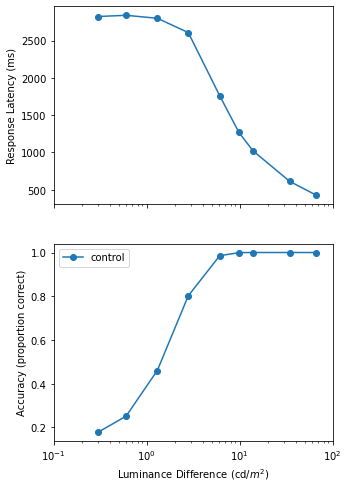

In [62]:
draw_RT_choice(25, 1.7)